# 1. Import Libraries

In [335]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from datetime import datetime

from typing import Literal
from pydantic import BaseModel

In [336]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 2. Load the Dataset

In [337]:
path = '/content/Student Depression Dataset.csv'
dataset = pd.read_csv(path)
print("Dataset Loaded:\n", dataset.head())

Dataset Loaded:
    id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Duration Dietary Habits   Degree  \
0          5-6 hours        Healthy  B.Pharm   
1          5-6 hours       Moderate      BSc   
2  Less than 5 hours        Healthy       BA 

In [338]:
print(dataset.shape)

(27901, 18)


In [339]:
dataset.dropna(inplace=True)

In [340]:
print(dataset.isnull().sum())

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


In [341]:
print(dataset.dtypes)

id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object


# 3. Preprocess the Dataset

In [342]:
dataset.drop(columns=['id'], inplace=True)
print('Column id is droped because it desnt affect the classification.')

Column id is droped because it desnt affect the classification.


In [343]:
print('Droped columns with alomst fixed value:')
for column in dataset.columns:
    counts = dataset[column].value_counts()
    threshold = 0.90
    for value in counts.keys():
        percentage = counts[value] / len(dataset)
        if percentage >= threshold:
            dataset.drop(columns=[column], inplace=True)
            print(f'{column}: {percentage * 100:.2f}% have the value [{value}]')
            break

Droped columns with alomst fixed value:
Profession: 99.89% have the value [Student]
Work Pressure: 99.99% have the value [0.0]
Job Satisfaction: 99.97% have the value [0.0]


In [344]:
dataset['Depression'] = dataset['Depression'].replace({0: -1})

In [345]:
def preprocess_dataset(dataset, target_columns):

    # Encode categorical variables
    le = LabelEncoder()

    for column in dataset.select_dtypes(include=['object']).columns:
        dataset[column] = le.fit_transform(dataset[column])


    sc = MinMaxScaler()
    columns = ['Gender', 'Age',  'City', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Sleep Duration',
               'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
               'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness']
    dataset[columns] = sc.fit_transform(dataset[columns])

    # Split dataset
    X = dataset.drop(columns=target_columns, axis=1)  # Features
    y = dataset[target_columns] # Target
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [346]:
X_train, X_test, y_train, y_test = preprocess_dataset(dataset, target_columns=['Depression'])
print("Data Preprocessing Completed.")

Data Preprocessing Completed.


In [347]:
print(dataset.dtypes)

Gender                                   float64
Age                                      float64
City                                     float64
Academic Pressure                        float64
CGPA                                     float64
Study Satisfaction                       float64
Sleep Duration                           float64
Dietary Habits                           float64
Degree                                   float64
Have you ever had suicidal thoughts ?    float64
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness         float64
Depression                                 int64
dtype: object


# 4. Utilities

In [348]:
def calculate_margin(w, X, y):
    return (X @ w.T) * y

In [349]:
def plot_margin(margins):
    margins = np.sort(margins.flatten())
    plt.plot(margins, c='k', linewidth=3)

    plt.axhline(y=0, c='k', linewidth=0.5)

    x = np.arange(len(margins))
    plt.gca().fill_between(x, margins, where=(margins>=0.3), color='#00ff00')
    plt.gca().fill_between(x, margins, where=(margins<=-0.3), color='#ff0000')
    plt.gca().fill_between(x, margins, where=np.bitwise_and(margins >= -0.3, margins <= 0.3), color='#ffff00')

    plt.ylabel("Margin")
    plt.gcf().set_size_inches(5, 3)

In [350]:
def plot_classifier_histories(classifier):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    axes[0].plot(classifier.loss_history, c='b')
    axes[0].set_title("Loss")

    axes[1].plot(classifier.Q_history, c='r')
    axes[1].set_title("Quality Functional")

In [351]:
def plot_histories(loss_history, Q_history):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    axes[0].plot(loss_history, c='b')
    axes[0].set_title("Loss")

    axes[1].plot(Q_history, c='r')
    axes[1].set_title("Quality Functional")

# 5. Reference Linear Classifier

In [352]:
reference_lc = SGDClassifier()
reference_lc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier()


Reference Linear Classifier

Execution Time: 2473 mcs

Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

          -1       0.87      0.72      0.79      2348
           1       0.82      0.92      0.87      3232

    accuracy                           0.84      5580
   macro avg       0.84      0.82      0.83      5580
weighted avg       0.84      0.84      0.83      5580


Confusion Matrix:



<Axes: >

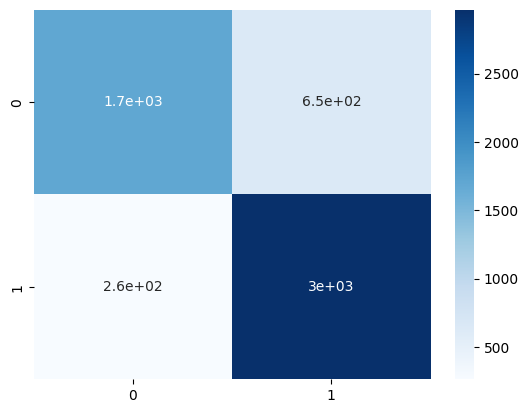

In [353]:
start_time = datetime.now()

y_pred = reference_lc.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nReference Linear Classifier")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

# 6. Custom Linear Classifier

In [354]:
class CustomLinearClassifier:
    def __init__(self, lr=0.01, max_iter=1000, reg=0.5, gamma=0.9,
                 momentum=False, optimize_lr=False, use_margins=False, initialization="correlation"):
        self.lr = lr
        self.max_iter = max_iter
        self.reg = reg
        self.gamma = gamma
        self.momentum = momentum
        self.optimize_lr = optimize_lr
        self.use_margins = use_margins
        self.initialization = initialization

        self.w = None
        self.Q = None

        self.v = 0

        self.loss_history = []
        self.Q_history = []

    def initialize_weights(self, X, y):
        n_features = X.shape[1]
        if self.initialization == "random":
            return np.random.uniform(low=-1 / (2 * n_features), high=1 / (2 * n_features), size=(1, n_features))
        elif self.initialization == "correlation":
            return np.array([(y.T @ X[:, i]) / (X[:, i].T @ X[:, i]) for i in range(X.shape[1])]).T

    def quadratic_margin_loss(self, w, X, y):
        M = (w @ X) * y
        return (1-M)**2

    def quadratic_margin_dloss(self, w, X, y):
        M = (w @ X) * y
        return -2*(1-M)*(y @ X.T)

    def fit(self, X, Y, lambda_=0.001):
        self.w = self.initialize_weights(X, Y)

        if self.Q is None:
            random_sample = np.random.choice(range(len(X)), size=(30))
            random_X_sample = X[random_sample]
            random_y_sample = Y[random_sample]

            self.Q = np.mean([self.quadratic_margin_loss(self.w, x, y) for (x, y) in zip(random_X_sample, random_y_sample)])

        for _ in range(self.max_iter):
            if self.use_margins:
                margins = ((X @ self.w.T) * Y).flatten()
                abs_inv_margins = max(abs(margins)) - abs(margins)
                abs_inv_margins = abs_inv_margins / sum(abs_inv_margins)
                idx = np.random.choice(np.arange(len(X)), p=abs_inv_margins)
                x, y = X[idx], Y[idx]
            else:
                x, y = random.choice(list(zip(X, Y)))

            x = x.reshape(-1, 1)
            y = y.reshape(-1, 1)

            l = self.quadratic_margin_loss(self.w, x, y)

            if self.optimize_lr:
                self.lr = 1 / sum(x**2)
            if self.momentum:
                self.v = self.gamma * self.v + (1 - self.gamma) * self.quadratic_margin_dloss(self.w - self.lr * self.gamma * self.v, x, y)
                self.w = self.w * (1 - self.lr * self.reg) - self.lr * self.v
            else:
                self.w = self.w * (1 - self.lr * self.reg) - self.lr * self.quadratic_margin_dloss(self.w, x, y)

            self.Q = lambda_ * l + (1-lambda_) * self.Q

            self.loss_history += [l[0, 0]]
            self.Q_history += [self.Q[0, 0]]

    def predict(self, X):
        return np.sign(X @ self.w.T)

## Initial Random Weights

In [355]:
custom_lc = CustomLinearClassifier(momentum=True, optimize_lr=True, use_margins=True, initialization="random")
custom_lc.fit(X_train, y_train)


Custom Linear Classifier With Initial Random Weights

Execution Time: 712 mcs

Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

          -1       0.65      0.74      0.69      2348
           1       0.79      0.71      0.75      3232

    accuracy                           0.72      5580
   macro avg       0.72      0.72      0.72      5580
weighted avg       0.73      0.72      0.72      5580


Confusion Matrix:



<Axes: >

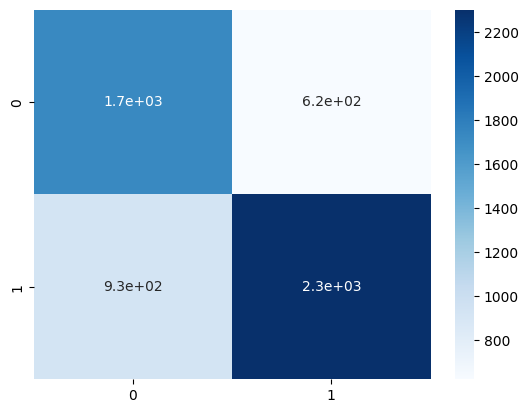

In [356]:
start_time = datetime.now()

y_pred = custom_lc.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nCustom Linear Classifier With Initial Random Weights")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

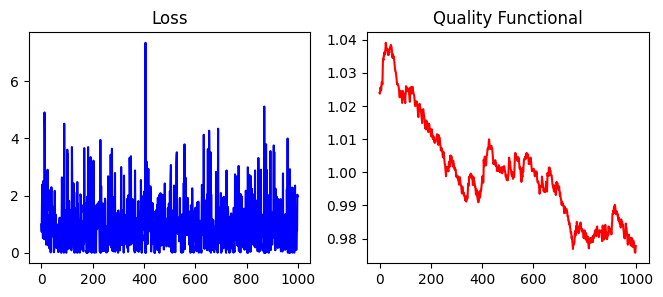

In [357]:
plot_classifier_histories(custom_lc)

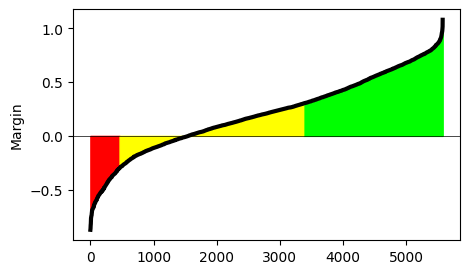

In [358]:
margins = calculate_margin(custom_lc.w, X_test, y_test)
plot_margin(margins)

## Initial MultiStart Weights

In [359]:
n_start = 25

best_accuracy = 0
best_time = 0
best_report = None
best_matrix = None
best_weights = None
best_lh = None
best_qh = None

for id in range(n_start):
    custom_lc = CustomLinearClassifier(momentum=True, optimize_lr=True, use_margins=True, initialization="random")
    custom_lc.fit(X_train, y_train)

    start_time = datetime.now()

    y_pred = custom_lc.predict(X_test)

    end_time = datetime.now()

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)

    if accuracy > best_accuracy:
        best_weights = custom_lc.w
        best_accuracy = accuracy
        best_time = end_time - start_time
        best_report = report
        best_matrix = matrix
        best_lh = custom_lc.loss_history
        best_qh = custom_lc.Q_history

    print(f'[{id}]: Accuracy: {accuracy:.2f}')

print(f'\nBest Weights: {best_weights}')

[0]: Accuracy: 0.74
[1]: Accuracy: 0.59
[2]: Accuracy: 0.56
[3]: Accuracy: 0.71
[4]: Accuracy: 0.77
[5]: Accuracy: 0.75
[6]: Accuracy: 0.72
[7]: Accuracy: 0.66
[8]: Accuracy: 0.74
[9]: Accuracy: 0.44
[10]: Accuracy: 0.69
[11]: Accuracy: 0.49
[12]: Accuracy: 0.73
[13]: Accuracy: 0.64
[14]: Accuracy: 0.58
[15]: Accuracy: 0.60
[16]: Accuracy: 0.65
[17]: Accuracy: 0.56
[18]: Accuracy: 0.59
[19]: Accuracy: 0.76
[20]: Accuracy: 0.65
[21]: Accuracy: 0.63
[22]: Accuracy: 0.70
[23]: Accuracy: 0.53
[24]: Accuracy: 0.63

Best Weights: [[-0.41615016 -0.16996526 -0.01537359  0.32515974 -0.15839347 -0.27275657
  -0.16120517 -0.10111889 -0.02488956  0.71295622  0.25876114  0.34328966
  -0.1029759 ]]



Custom Linear Classifier With Initial MultiStart Weights

Best Weights: [[-0.41615016 -0.16996526 -0.01537359  0.32515974 -0.15839347 -0.27275657
  -0.16120517 -0.10111889 -0.02488956  0.71295622  0.25876114  0.34328966
  -0.1029759 ]]

Execution Time: 1919 mcs

Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

          -1       0.82      0.58      0.68      2348
           1       0.75      0.91      0.82      3232

    accuracy                           0.77      5580
   macro avg       0.78      0.74      0.75      5580
weighted avg       0.78      0.77      0.76      5580


Confusion Matrix:



<Axes: >

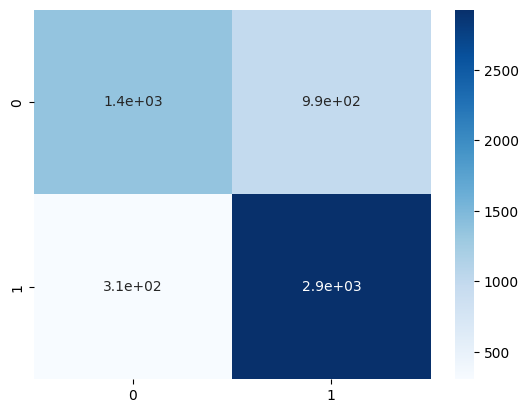

In [360]:
print(f"\nCustom Linear Classifier With Initial MultiStart Weights")
print(f"\nBest Weights: {best_weights}")
print(f"\nExecution Time: {best_time.microseconds} mcs")
print(f"\nAccuracy: {best_accuracy:.2f}")
print("\nClassification Report:\n", best_report)
print("\nConfusion Matrix:\n")
sns.heatmap(best_matrix, annot=True, cmap="Blues")

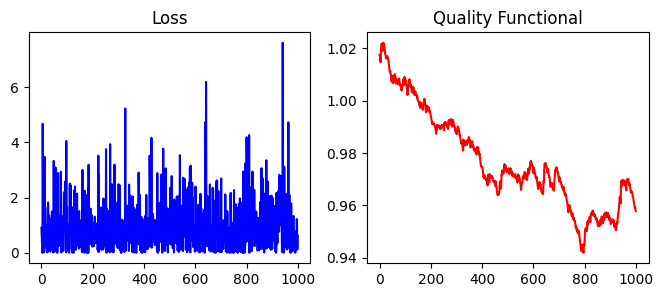

In [361]:
plot_histories(best_lh, best_qh)

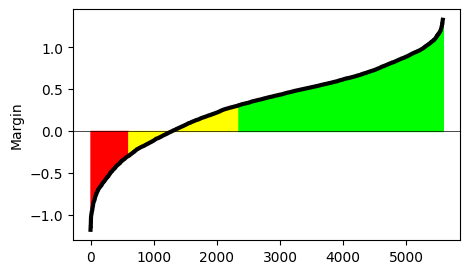

In [362]:
margins = calculate_margin(best_weights, X_test, y_test)
plot_margin(margins)

## Initial Correlation Weights

In [363]:
custom_lc = CustomLinearClassifier(momentum=True, optimize_lr=True, use_margins=True, initialization="correlation")
custom_lc.fit(X_train, y_train)


Custom Linear Classifier With Initial Correlation Weights

Execution Time: 8475 mcs

Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

          -1       0.74      0.51      0.61      2348
           1       0.71      0.87      0.78      3232

    accuracy                           0.72      5580
   macro avg       0.72      0.69      0.69      5580
weighted avg       0.72      0.72      0.71      5580


Confusion Matrix:



<Axes: >

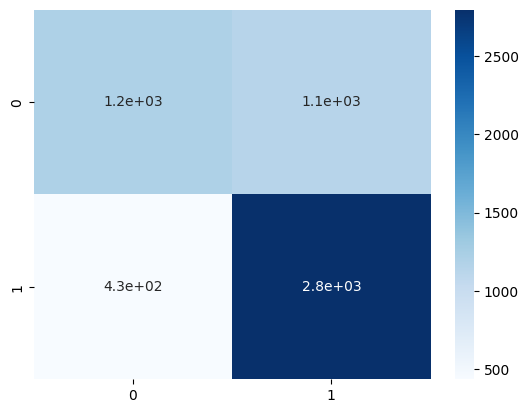

In [367]:
start_time = datetime.now()

y_pred = custom_lc.predict(X_test)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nCustom Linear Classifier With Initial Correlation Weights")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

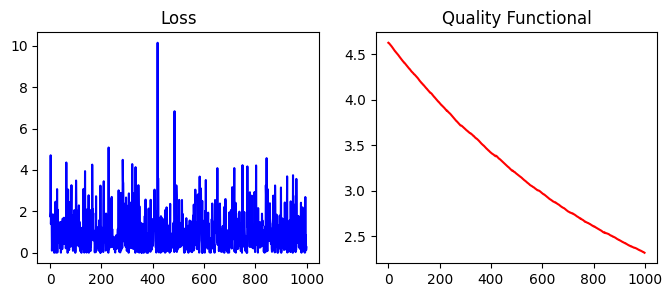

In [368]:
plot_classifier_histories(custom_lc)

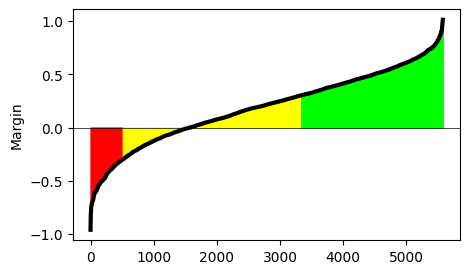

In [369]:
margins = calculate_margin(custom_lc.w, X_test, y_test)
plot_margin(margins)